# Behavioral Cloning

## Model

### Code
Note that the code not directly related to defining and training the model in `model.py` has been modularized and extracted into separate Python files. For example, a Python generator inheriting from the parent class of Keras' ImageDataGenerator is implemented in `dataframe_iterator.py`.

### Architecture
Because Comma.ai's success has been proven in the real-world, their open source steering model (https://github.com/commaai/research/blob/master/train_steering_model.py) was used in this project. However, instead of their initial Lambda layer, which only mean-centers the images, a batchnorm layer is used for input data normalization.

#### Input Image Size
64x32 was chosen to match the original aspect ratio. Keeping the original image size of 320x160 would significantly slow down model training. And, others have reported success with 64x64 images.

#### Non-Linear Activation Layers
One notable characteristic of the Comma.ai model, besides its simplicity, is the use of ELU's instead of the popular ReLU's. The benefits of ELU's over ReLU's have been published in https://arxiv.org/pdf/1511.07289v1.pdf

#### No Pooling
As mentioned in https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.tlhopk40h, there are no pooling layers because they help with translation invariance. However, we need to adjust the steering angle proportional to horizontal translation.

#### Summary
One can easily see the details of the layers from the source code, but the model contains:
* batchnorm input layer, as described above
* Convolutional Section -- 3 2D convolutional layers with ELU activation layers before and after the middle convolutional layer:
    * 16 filters, 8x8 kernel, stride of 4
    * 32 filters, 5x5 kernel, stride of 2
    * 64 filters, 5x5 kernel, stride of 2
* Flattening: Needed because dense layers in the next section expect vectors.
* Fully-Connected Section -- 2 dense layers of the following output sizes, each preceded by a dropout layer and an ELU activation layer:
    * 512 
    * 1 for the final output

##### Output
The predicted steering angle is output from single dense layer of size 1 without an activation.

### Optimizer
Adam with Nesterov momentum (i.e., "Nadam" in Keras) was used. The benefits of Nadam compared to Adam are discussed in the paper linked in Keras' documentation -- http://cs229.stanford.edu/proj2015/054_report.pdf

## Data Generation & Collection

### Joystick
Because other people reported better results with video game controllers instead of the keyboard, the Speedlink O.Z. Racing Wheel controller (http://www.speedlink.com/?p=2&cat=4329&pid=27305&paus=1) was used for this project.

### Simulator Settings
* Only race track 1 was used to generate training data
* For EACH direction of the track (i.e. clockwise & counter-clockwise):
    * In order to give a potentially wider variety of training data for the model, 2 laps of **slow, center-line** driving were driven in each of the following screen resolutions & graphics quality settings:
        * 640x480, fastest
        * 1400x1050, fantastic

### Original Images & Steering Angle Adjustment
Images from all 3 simulated cameras (left, center, right) were used. A steering angle adjustment of +/- 0.07 were added onto the steering angle when using the left/right images. The angle adjustment was derived empirically by trial and error of the model on the simulator. Higher and higher values resulted in zig-zag, oscillated driving.

Below are the number of images generated with slow, centerline driving on the 50 Hz simulator:

In [1]:
from training_validation import parent_directories

for directory in parent_directories:
    !echo {directory} `ls -al {directory}/IMG | wc -l`

data/track1/forward/center 107058
data/track1/backward/center 128763


### Augmentation of Images
As noted in https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.tlhopk40h, the steering angles in this project's generated dataset are also biased towards zero. But, the distribution of left/right steering is more balanced due to driving both clockwise and counter-clockwise on the track:

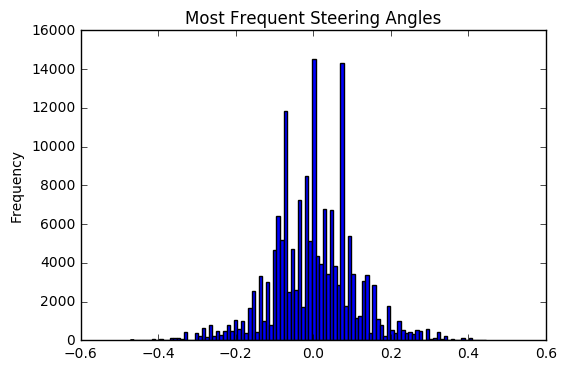

In [2]:
%matplotlib inline

from training_validation import build_dataframes

training_samples, validation_samples = build_dataframes()

steering_angles = training_samples['steering_angle']
steering_angles.plot.hist(bins=100, title="Most Frequent Steering Angles")

To generate an even greater variety of training data, random brightness changes and translations (both vertical and horizontal) were applied to images as described in https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.tlhopk40h. However, the image augmentation functions were implemented with the Python Imaging Library (PIL) instead of OpenCV.

Additionally, the following were also implemented:
* Cropping out a reasonable amount of the sky and hood of the car in order to ensure the model can "focus" on the most relevant parts of the image and learn to steer based on lane lines.
* Random horizontal image flipping derived from Keras' ImageDataGenerator open source code

Finally, the image is resized to the expected model input size of 64x32.

#### Example Left, Center, Right Images

steering angle -0.007274489


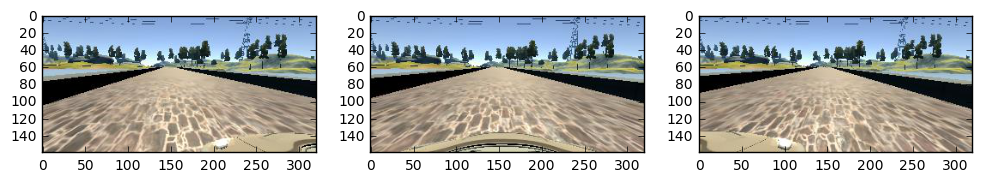

In [3]:
import pandas as pd
from training_validation import column_names
from PIL import Image
import matplotlib.pyplot as plt

training_samples = pd.read_csv(parent_directories[0] + '/driving_log.csv', header=None, names=column_names, low_memory=False)
test_sample =  training_samples.sample(1).iloc[0]
center_img_filepath = test_sample['center_image'].strip()
left_img_filepath = test_sample['left_image'].strip()
right_img_filepath = test_sample['right_image'].strip()
steering_angle = test_sample['steering_angle']
print('steering angle', steering_angle)
filepaths = [left_img_filepath, center_img_filepath, right_img_filepath]
fig = plt.figure(figsize=(12, 6))
filepaths_count = len(filepaths)
rows = 1
for i in range(filepaths_count):
    sp = fig.add_subplot(rows, filepaths_count//rows, i+1)
    img = Image.open(filepaths[i])
    plt.imshow(img)

#### Example Augmentations

translated steering angle 0.0261531866729


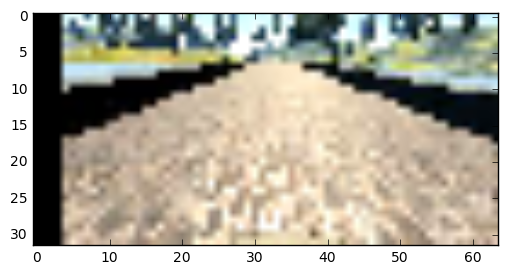

In [4]:
from img_transformations import translate, brighten_or_darken, cropout_sky_hood

img = Image.open(center_img_filepath)
img = brighten_or_darken(img, brightness_factor_min=0.25)
img, steering_angle = translate(img, steering_angle)
img = cropout_sky_hood(img)
print('translated steering angle', steering_angle)
img = img.resize((64, 32))
plt.imshow(img)

## Training/Validation/Testing

* Model was trained for 8 epochs
* Mean square error of the predicted steering angle was the loss function that the model was evaluated on.
* Using Keras' Model Checkpoint, the model weights are auto-saved after an epoch if validation loss improved over the previous best validation loss. The model weight filename includes the epoch number.
* Each model weight file is loaded and **tested** against the simulator, and not a separate set of test images, for evaluation. As other people have reported, the model weights with the lowest training or validation loss doesn't necessarily perform the best on the race track.
* If the simulated car drives around track 1 continuously within the lane boundaries for several laps, a copy of the model weights file is saved as `model.h5`

## Simulation

Recommended settings: 640x480, fastest

`drive.py` changes:
* `cropout_sky_hood()`, previously mentioned in the "Augmentation of Images" subsection, is applied here in order to closely match the images that the model was trained on
* image resized to the model's expected input shape
* throttle has been changed to a constant of 0.1, which is slow enough for the model to keep the vehicle driving within lane boundaries. The vehicle doesn't drive perfectly on the center line on the relatively sharp turn section after the bridge, despite the slow, careful driving done to generate the training data. Perhaps adding the shearing image augmentation mentioned in https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.tlhopk40h would help. Another future extention to the model would be to have an additional output for throttle...

When run in the highest screen resolution and quality settings, there is a noticeable lag in the responsiveness of the vehicle's deep neural network model to generate a steering angle prediction. One can imagine that real world autonomous vehicle engineers must optimize their hardware and software to make safety-critical decisions as fast as possible...

Race track 2 not yet supported.